## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
import random
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))


3718
196


In [5]:
print(train_set[:40])

[[('The', 'DET'), ('Department', 'NOUN'), ('of', 'ADP'), ('Health', 'NOUN'), ('and', 'CONJ'), ('Human', 'NOUN'), ('Services', 'NOUN'), ('plans', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('extend', 'VERB'), ('its', 'PRON'), ('moratorium', 'NOUN'), ('on', 'ADP'), ('federal', 'ADJ'), ('funding', 'NOUN'), ('of', 'ADP'), ('research', 'NOUN'), ('involving', 'VERB'), ('fetal-tissue', 'ADJ'), ('transplants', 'NOUN'), ('.', '.')], [('Olympia', 'NOUN'), ('Broadcasting', 'NOUN'), ('Corp.', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('did', 'VERB'), ("n't", 'ADV'), ('make', 'VERB'), ('a', 'DET'), ('$', '.'), ('1.64', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('semiannual', 'ADJ'), ('interest', 'NOUN'), ('payment', 'NOUN'), ('due', 'ADJ'), ('yesterday', 'NOUN'), ('on', 'ADP'), ('$', '.'), ('23.4', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('senior', 'ADJ'), ('subordinated', 'VERB'), ('debentures', 'NOUN'), ('.', '.')], [('In', 'ADP'), ('part', 'NOUN'), (',', '.'), ('prices',

In [6]:
#Training Data
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95640

In [7]:
# Test Data
validation = [tup for sent in test_set for tup in sent]
len(validation)

5036

In [8]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'Department',
 'of',
 'Health',
 'and',
 'Human',
 'Services',
 'plans',
 '*-1',
 'to']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12073


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
print(T)

{'CONJ', 'VERB', 'PRON', 'NOUN', 'ADP', 'ADJ', 'PRT', 'ADV', 'DET', 'X', 'NUM', '.'}


### POS Tagging Algorithm - HMM

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

##### Emission Probability

In [13]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# bonus
print("\n", "bonus")
print(word_given_tag('bonus', 'ADJ'))
print(word_given_tag('bonus', 'VERB'))
print(word_given_tag('bonus', 'NOUN'), "\n")

# will
print("\n", "offering")
print(word_given_tag('offering', 'VERB'))
print(word_given_tag('offering', 'NOUN'))

# book
print("\n", "retirement")
print(word_given_tag('retirement', 'NOUN'))
print(word_given_tag('retirement', 'VERB'))


 bonus
(0, 6083)
(0, 12902)
(6, 27411) 


 offering
(10, 12902)
(14, 27411)

 retirement
(10, 27411)
(0, 12902)


##### Transition Probability

In [15]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('VERB', 'NOUN'))

(4252, 6083)
(5286, 8291)
(1435, 12902)
(6606, 27411)
(4026, 27411)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[4.65332705e-04, 1.54025123e-01, 6.04932532e-02, 3.51791531e-01,
        5.11865988e-02, 1.20521173e-01, 4.65332717e-03, 5.39785959e-02,
        1.20055839e-01, 8.37598927e-03, 4.18799445e-02, 3.25732902e-02],
       [5.42551558e-03, 1.68190971e-01, 3.55758779e-02, 1.11223064e-01,
        9.06061083e-02, 6.55712262e-02, 3.10804527e-02, 8.16927627e-02,
        1.35327861e-01, 2.17718184e-01, 2.24771351e-02, 3.51108350e-02],
       [4.98084305e-03, 4.85823750e-01, 7.66283507e-03, 2.09195405e-01,
        2.29885057e-02, 7.16475099e-02, 1.22605367e-02, 3.40996161e-02,
        8.42911843e-03, 9.46360156e-02, 7.66283507e-03, 4.06130254e-02],
       [4.28295210e-02, 1.46875337e-01, 4.77910321e-03, 2.63179004e-01,
        1.76972747e-01, 1.18200723e-02, 4.33402658e-02, 1.71464011e-02,
        1.33887855e-02, 2.90394370e-02, 9.63116996e-03, 2.40998134e-01],
       [8.54062149e-04, 8.64737947e-03, 6.92857876e-02, 3.21447641e-01,
        1.70812421e-02, 1.07611828e-01, 1.38785096e-03, 1.38

In [19]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,CONJ,VERB,PRON,NOUN,ADP,ADJ,PRT,ADV,DET,X,NUM,.
CONJ,0.000465,0.154025,0.060493,0.351792,0.051187,0.120521,0.004653,0.053979,0.120056,0.008376,0.041880,0.032573
VERB,0.005426,0.168191,0.035576,0.111223,0.090606,0.065571,0.031080,0.081693,0.135328,0.217718,0.022477,0.035111
PRON,0.004981,0.485824,0.007663,0.209195,0.022989,0.071648,0.012261,0.034100,0.008429,0.094636,0.007663,0.040613
NOUN,0.042830,0.146875,0.004779,0.263179,0.176973,0.011820,0.043340,0.017146,0.013389,0.029039,0.009631,0.240998
ADP,0.000854,0.008647,0.069286,0.321448,0.017081,0.107612,0.001388,0.013879,0.323583,0.035123,0.062240,0.038860
ADJ,0.016275,0.012329,0.000658,0.698997,0.077265,0.067894,0.010357,0.004767,0.005096,0.021371,0.020056,0.064935
PRT,0.001978,0.402242,0.017474,0.248269,0.021101,0.084405,0.001649,0.009891,0.099571,0.013518,0.056710,0.043192
ADV,0.006965,0.342952,0.015257,0.031177,0.117413,0.129685,0.013599,0.079934,0.068657,0.023217,0.032172,0.138972
DET,0.000482,0.039923,0.003498,0.637559,0.009408,0.204680,0.000241,0.012664,0.005548,0.046798,0.021228,0.017971
X,0.010319,0.207335,0.056199,0.062073,0.145102,0.016193,0.184791,0.024925,0.053977,0.073980,0.002858,0.162248


In [20]:
tags_df.loc['.', :]

CONJ    0.057746
VERB    0.089627
PRON    0.065559
NOUN    0.222721
ADP     0.091872
ADJ     0.044005
PRT     0.002335
ADV     0.052537
DET     0.173327
X       0.026852
NUM     0.080467
.       0.092860
Name: ., dtype: float32

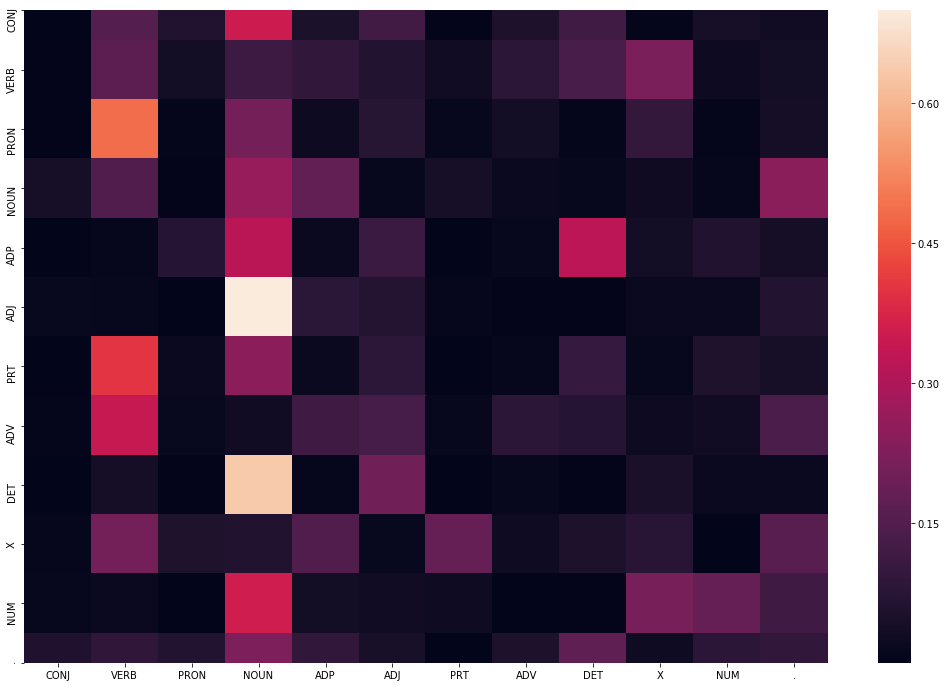

In [21]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [22]:
len(train_tagged_words)

95640

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
# list of tagged words
validation_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in test_set for tup in sent]
print(len(test_set))
print(len(validation_tagged_words))

196
5036


In [25]:
import random
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]


In [26]:
# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Old', 'NOUN'),
  ('Spaghetti', 'NOUN'),
  ('Warehouse', 'NOUN'),
  ('rose', 'VERB'),
  ('1', 'NUM'),
  ('to', 'PRT'),
  ('16', 'NUM'),
  ('1\\/8', 'NUM'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('can', 'VERB'),
  ('Mr.', 'NOUN'),
  ('Hahn', 'NOUN'),
  ('carry', 'VERB'),
  ('it', 'PRON'),
  ('off', 'ADP'),
  ('?', '.')],
 [('From', 'ADP'),
  ('January', 'NOUN'),
  ('to', 'PRT'),
  ('October', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('nation', 'NOUN'),
  ("'s", 'PRT'),
  ('accumulated', 'VERB'),
  ('exports', 'NOUN'),
  ('increased', 'VERB'),
  ('4', 'NUM'),
  ('%', 'NOUN'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('same', 'ADJ'),
  ('period', 'NOUN'),
  ('last', 'ADJ'),
  ('year', 'NOUN'),
  ('to', 'PRT'),
  ('$', '.'),
  ('50.45', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  ('.', '.')],
 [('``', '.'),
  ('The', 'DET'),
  ('agency', 'NOUN'),
  ('publicly', 'ADV'),
  ('and', 'CONJ'),
  ('officially', 'ADV'),
  ('declared', 'VERB'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('lawsuit', 

In [27]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [28]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  20.71616506576538
[('Old', 'NOUN'), ('Spaghetti', 'CONJ'), ('Warehouse', 'CONJ'), ('rose', 'VERB'), ('1', 'NUM'), ('to', 'PRT'), ('16', 'NUM'), ('1\\/8', 'NUM'), ('.', '.'), ('But', 'CONJ'), ('can', 'VERB'), ('Mr.', 'NOUN'), ('Hahn', 'NOUN'), ('carry', 'VERB'), ('it', 'PRON'), ('off', 'PRT'), ('?', '.'), ('From', 'ADP'), ('January', 'NOUN'), ('to', 'PRT'), ('October', 'NOUN'), (',', '.'), ('the', 'DET'), ('nation', 'NOUN'), ("'s", 'PRT'), ('accumulated', 'CONJ'), ('exports', 'NOUN'), ('increased', 'VERB'), ('4', 'NUM'), ('%', 'NOUN'), ('from', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('period', 'NOUN'), ('last', 'ADJ'), ('year', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('50.45', 'CONJ'), ('billion', 'NUM'), ('*U*', 'X'), ('.', '.'), ('``', '.'), ('The', 'DET'), ('agency', 'NOUN'), ('publicly', 'ADV'), ('and', 'CONJ'), ('officially', 'ADV'), ('declared', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('lawsuit', 'NOUN'), ('that', 'ADP'), ('persons', 'NOUN'), ('who', 'PRON'),

In [29]:
print(len(validation_tagged_words))

5036


In [30]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.875

In [31]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [32]:
incorrect_tagged_cases

[[('Old', 'NOUN'), (('Spaghetti', 'CONJ'), ('Spaghetti', 'NOUN'))],
 [('Spaghetti', 'NOUN'), (('Warehouse', 'CONJ'), ('Warehouse', 'NOUN'))],
 [('it', 'PRON'), (('off', 'PRT'), ('off', 'ADP'))],
 [("'s", 'PRT'), (('accumulated', 'CONJ'), ('accumulated', 'VERB'))],
 [('$', '.'), (('50.45', 'CONJ'), ('50.45', 'NUM'))],
 [('*T*-24', 'X'), (('examine', 'CONJ'), ('examine', 'VERB'))],
 [('take', 'VERB'), (('verbatim', 'CONJ'), ('verbatim', 'ADJ'))],
 [('no', 'DET'), (('one', 'NUM'), ('one', 'NOUN'))],
 [('determine', 'VERB'), (('what', 'PRON'), ('what', 'DET'))],
 [('.', '.'), (('Foreigners', 'CONJ'), ('Foreigners', 'NOUN'))],
 [('Foreigners', 'NOUN'), (('complain', 'CONJ'), ('complain', 'VERB'))],
 [('complain', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [('have', 'VERB'), (('limited', 'VERB'), ('limited', 'ADJ'))],
 [('government', 'NOUN'), (('procurement', 'CONJ'), ('procurement', 'NOUN'))],
 [('unfairly', 'ADV'), (('undercut', 'CONJ'), ('undercut', 'VERB'))]]

In [33]:
#Testing with test sample 
test_cases_shared = 'Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
test_words = word_tokenize(test_cases_shared)

In [34]:
start = time.time()
tagged_seq = Viterbi(test_words)
end = time.time()
difference = end-start

In [35]:
# list of tagged words
validation_run_test = [tup for sent in test_words for tup in sent]

# list of untagged words
validation_tagged_words1 = [tup[0] for sent in test_words for tup in sent]
print(len(test_words))
print(len(validation_tagged_words1))

182
827


In [36]:
print(difference)
print(len(tagged_seq))
print(tagged_seq)

29.28235125541687
182
[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'CONJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'VERB'), ('firehose', 'CONJ'), ('.', '.'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 

In [37]:
tags = [pair[1] for pair in tagged_seq]
unique_tags = set(tags)
len(unique_tags)

11

In [38]:
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'CONJ': 44,
         'VERB': 21,
         'DET': 20,
         'ADJ': 7,
         'NOUN': 42,
         'ADP': 22,
         '.': 13,
         'PRT': 6,
         'ADV': 1,
         'NUM': 2,
         'PRON': 4})

Noun is the most common tag. Hence 

### Solve the problem of unknown words

Modification 1

In [39]:
#Replace all unknown words are by Noun (Noun being the most common tag) 

def Viterbi_Noun(test_words, train_bag = train_tagged_words):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    for key, word in enumerate(words):
        if word not in V:
            Viterbi_tags[key] = 'NOUN'
            
    
    return list(zip(words, Viterbi_tags))

In [40]:
#It takes more time beacuse of words length
# start = time.time()
# tagged_seq1_test = Viterbi_Noun(validation_tagged_words)
# end = time.time()
# difference = end-start

In [41]:
start = time.time()
tagged_seq2_test1 = Viterbi_Noun(test_words)
end = time.time()
difference = end-start

In [42]:
check_mod = [i for i, j in zip(tagged_seq2_test1, validation_run_base) if i == j] 
accuracy = len(check_mod)/len(tagged_seq2_test1)
accuracy

0.01098901098901099

Modification-2

In [43]:
def Viterbi_Adj(test_words, train_bag = train_tagged_words):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            ## word ending with '-ous'
            if word[-3:] == 'ous':
                Viterbi_tags[key] = 'ADJ'
                
            ## first letter is capitalised:
            elif word[0].upper() == word[0]:  #Eg: Google, Android
                Viterbi_tags[key] = 'NOUN' 
                
            else: 
                Viterbi_tags[key] = 'NOUN'
    
    return list(zip(words, Viterbi_tags))

In [44]:
start = time.time()
tagged_seq2_test2 = Viterbi_Adj(test_words)
end = time.time()
difference = end-start

In [45]:
check_mod = [i for i, j in zip(tagged_seq2_test2, validation_run_base) if i == j] 
accuracy = len(check_mod)/len(tagged_seq2_test2)
accuracy

0.01098901098901099

Lexicon (Unigram) Tagger¶
Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word.

In NLTK, the UnigramTagger() can be used to train such a model.

In [46]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is ", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is  0.9023034154090548


Rule-Based (Regular Expression) Tagger
Now let's build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() 
can be provided with handwritten regular expression patterns, as shown below.

In [47]:
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN'),                    # nouns
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [48]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)

In [49]:
#Evaluating based on rule_based_unigram_tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram RegexpTagger =", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram RegexpTagger = 0.9023034154090548


#### Evaluating tagging accuracy

Accurancy of Vertibi Algorithm = 0.88 

Accuracy of Vertibi Modification = 0.0

Accuracy of Lexicon unigram tagger = 0.90

Accuracy of Rulebased RegexpTagger = 0.90

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In comparision Lexicon unigram tagger, Vertibi algorithm and RegexpTagger shows good accuracy.

Combining the taggers also results in 0.90 as accuracy

In [50]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9023034154090548

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

I've tried the modifications for the words ending with 'ous' should be tagged as ADJ and Upper case Words should
be noun. Modifications are not having the significance improvement in the accurancy. Hence conculding the POS tagger
are correctly tagged with the max accuracy of 90%.